***Import Libraries***

In [201]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

***Load the Dataset***


In [202]:
data=pd.read_csv("Fraud.csv")

***Exploring the Dataset***

Numerical Attributes

In [203]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


Categorical Attributes

In [204]:
data.describe(include="object")

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


isFraud and isFlaggedFraud does not have outliers as they have values between 0 and 1.

In [205]:
data.shape

(6362620, 11)

Check for missing values in our dataset, and handle them.

In [206]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [207]:
data.isnull().values.any()

False

There are no missing values in this data

***Lets Explore Outliers***

Column Name = step


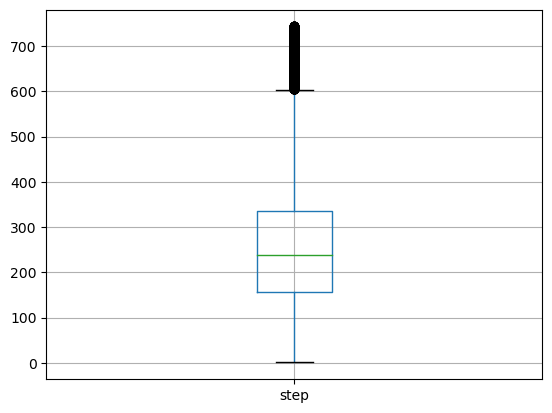

Column Name = amount


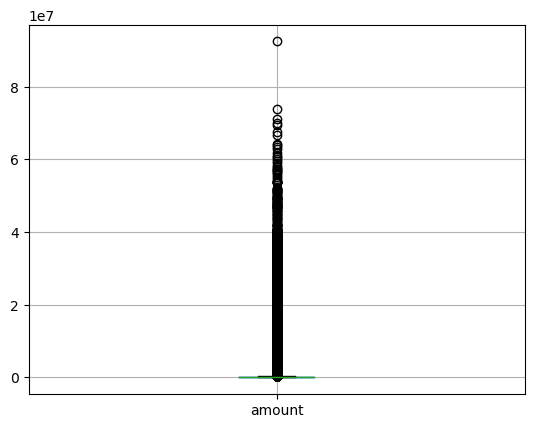

Column Name = oldbalanceOrg


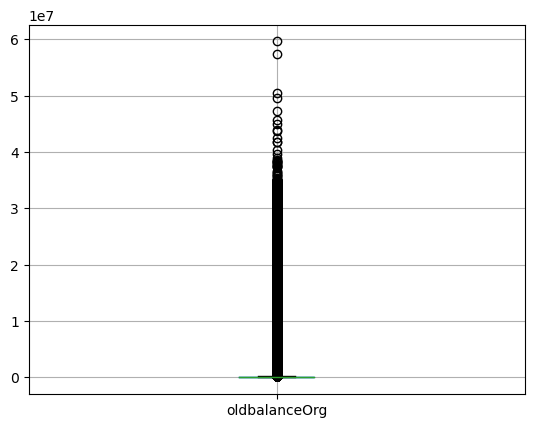

Column Name = newbalanceOrig


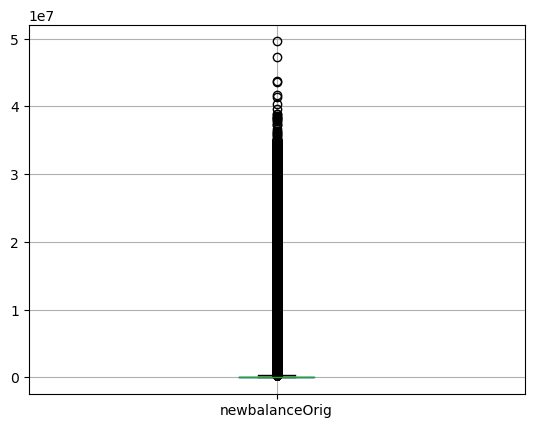

Column Name = oldbalanceDest


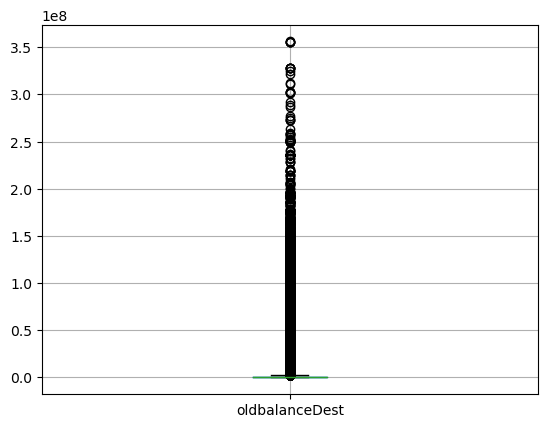

Column Name = newbalanceDest


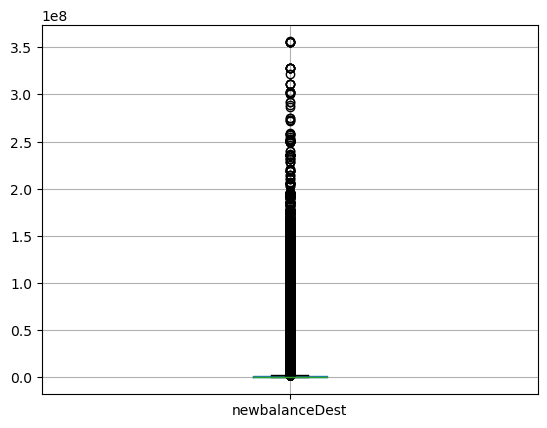

Column Name = isFraud


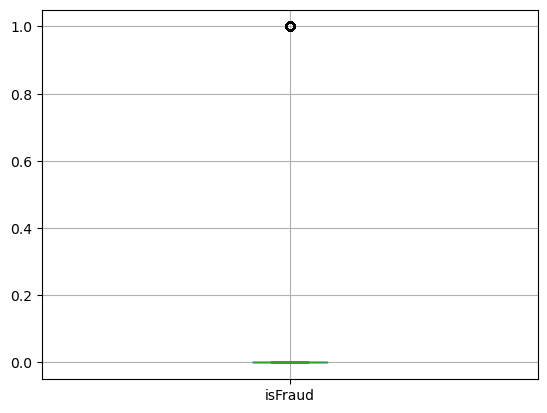

Column Name = isFlaggedFraud


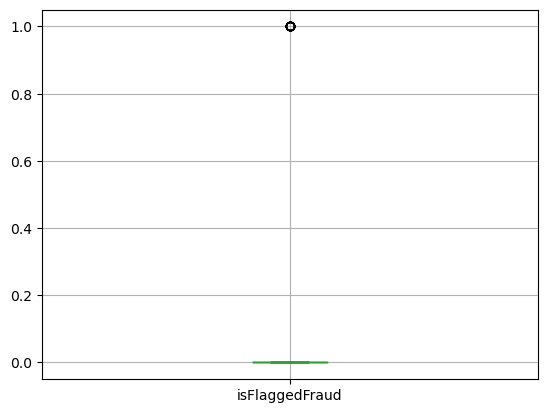

In [8]:
#using box plot, we can check for outliers in every column
for feature in data.columns:
    if data[feature].dtype == 'float64' or data[feature].dtype == 'int64':
        print("Column Name = " + feature)
        data.boxplot(column = feature)
        plt.show()
    else:
        pass

isFraud and isFlaggedFraud has values between 0 and 1, while other columns has outliers.

In [208]:
data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [209]:
data.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

The number of non-fraudulent transactions is very high compared to the fraudulent ones. Our class variable contains data which is highly skewed towards the flag value 0, which would indeed affect any models we might train on this dataset.

**Plotting attribute type**

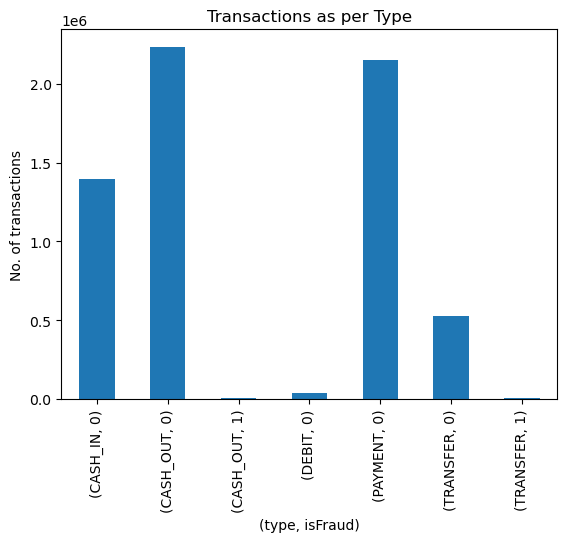

In [210]:
axes = data.groupby(['type', 'isFraud']).size().plot.bar()
axes = data.groupby(['type', 'isFraud']).size().plot.bar()
axes.set_title('Transactions as per Type')
axes.set_xlabel('(type, isFraud)')
axes.set_ylabel('No. of transactions')
axes.plot()
plt.show()

This plot shows us that only type CASH_OUT and type TRANSFER transactions can be fraudulent, and we can therefore remove the entries which have a different transaction type.

In [211]:
data = data.loc[~(data['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]
data

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


newbalanceDest == oldbalanceDest + amount, and newbalanceOrig == oldbalanceOrg - amount. We will now check these conditions.

In [212]:
data.loc[data['newbalanceOrig'] != data['oldbalanceOrg'] - data['amount']].shape


(2596313, 11)

In [213]:
data.loc[data['newbalanceDest'] != data['oldbalanceDest'] + data['amount']].shape

(1166184, 11)

So, in most transactions, balances are not accurately captured

In [214]:
data['origBal_inacc'] = (data['oldbalanceOrg'] - data['amount']) - data['newbalanceOrig']
data['destBal_inacc'] = (data['oldbalanceDest'] + data['amount']) - data['newbalanceDest']

data[['origBal_inacc', 'destBal_inacc']]

,origBal_inacc,destBal_inacc
2,0.00,1.810000e+02
3,0.00,2.136300e+04
15,-213808.94,1.827035e+05
19,-214605.30,2.377353e+05
24,-300850.89,-2.401220e+06
...,...,...
6362615,0.00,0.000000e+00
6362616,0.00,6.311409e+06
6362617,0.00,1.000000e-02
6362618,0.00,8.500025e+05


***Checking Multicollinearity***

In [215]:
#checking for multicollinearity
data.corr()

C:\Users\shive\AppData\Local\Temp\ipykernel_19064\873420997.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origBal_inacc,destBal_inacc
step,1.000000,0.037007,0.005744,-0.011280,0.037778,0.037475,0.048671,0.005015,-0.033936,0.029010
amount,0.037007,1.000000,0.120389,0.018296,0.307133,0.497027,0.070660,0.012301,-0.982838,-0.234198
oldbalanceOrg,0.005744,0.120389,1.000000,0.778826,-0.020403,-0.010029,0.347582,0.074300,0.030438,0.113853
newbalanceOrig,-0.011280,0.018296,0.778826,1.000000,-0.012277,-0.015439,0.063557,0.123957,0.032263,0.061630
oldbalanceDest,0.037778,0.307133,-0.020403,-0.012277,1.000000,0.970060,-0.014960,-0.000969,-0.315245,-0.065281
newbalanceDest,0.037475,0.497027,-0.010029,-0.015439,0.970060,1.000000,-0.008978,-0.001053,-0.504317,-0.230329
isFraud,0.048671,0.070660,0.347582,0.063557,-0.014960,-0.008978,1.000000,0.044072,0.017149,0.069935
isFlaggedFraud,0.005015,0.012301,0.074300,0.123957,-0.000969,-0.001053,0.044072,1.000000,-0.012562,0.019802
origBal_inacc,-0.033936,-0.982838,0.030438,0.032263,-0.315245,-0.504317,0.017149,-0.012562,1.000000,0.259573
destBal_inacc,0.029010,-0.234198,0.113853,0.061630,-0.065281,-0.230329,0.069935,0.019802,0.259573,1.000000


C:\Users\shive\AppData\Local\Temp\ipykernel_19064\918307094.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


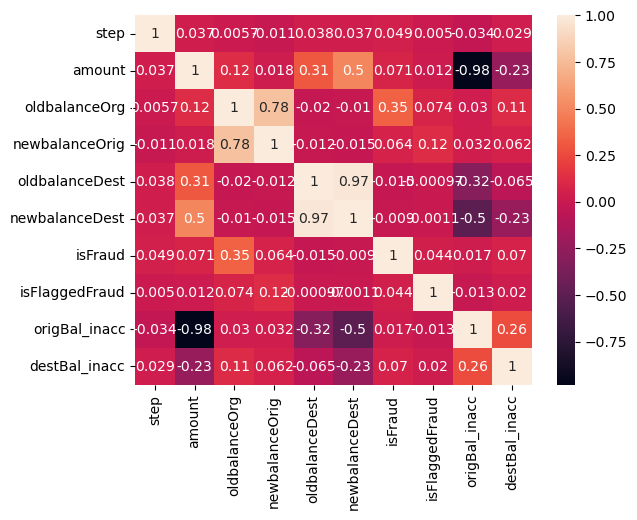

In [216]:
# Heatmap of the correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [217]:
# Drop the original balance columns
data.drop(['newbalanceOrig', 'newbalanceDest'], axis=1, inplace=True)

C:\Users\shive\AppData\Local\Temp\ipykernel_19064\918307094.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


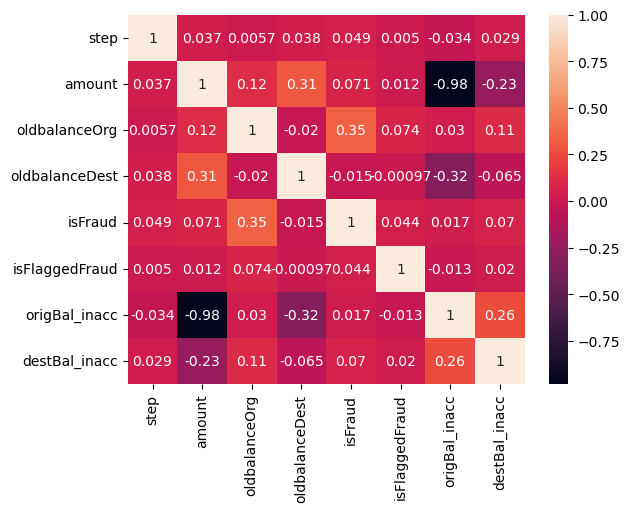

In [218]:
# Heatmap of the correlation matrix
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

By plotting heatmap again, the difference is clearily visible.

C:\Users\shive\AppData\Local\Temp\ipykernel_19064\1821173288.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


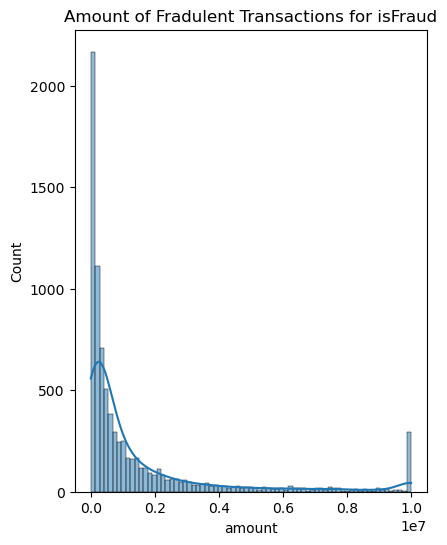

In [219]:
figure = plt.subplots(figsize = (10, 6))

plt.subplot(121)
ax = sns.histplot(data=data[data['isFraud']==1],x='amount', kde=True)
plt.title('Amount of Fradulent Transactions for isFraud')

plt.show()

We can see that fraud happens only when amount is low.

# ***Data preprocessing***

***Using Column Transformer****

We will use one hot encoding on variable type and standard scaling on remaining variable.

In [220]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
data['nameOrig'] = labelEncoder.fit_transform(data['nameOrig'])
data['nameDest'] = labelEncoder.fit_transform(data['nameDest'])

ct = ColumnTransformer(transformers=[("ohencode",OneHotEncoder(handle_unknown="ignore"),[1]), ("stdscaler",StandardScaler(),[0,2,4,6,8,9])],remainder='passthrough')

***Handling Imbalanced Dataset***

There are many techniques to handle imbalanced data like undersampling, oversampling, smote, tree based algorithms.

With undersampling and then training the model with decision tree, I got f1scoreof 0.91. But, Undersampling may result in loss of valuable information.

With oversampling and then train model with decision tree. I got f1score of 0.93. But, Oversampling may lead to overfitting. 


SMOTE with RandomForestClassifier model I got f1score of 0.99. But, this may also be overfitting.

**After trying all the above mentioned techniques, I tried Balanced Bagging Classifier and Random Forest Classifier.**

In [221]:
#Create an instance
bbcmodel = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
rfcmodel = RandomForestClassifier()

# **Train Test Split**

In [222]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = data.drop(['isFraud'], axis=1)  # Features
y = data['isFraud']  # Target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ***Using Pipileine***

In [228]:
#try rfcpipeline for randomforest model or bbcpipeline for balancedbagging model

rfcpipeline = Pipeline(steps=[('column_transformer', ct), ('model',rfcmodel)])
bbcpipeline = Pipeline(steps=[('column_transformer', ct), ('model',bbcmodel)])

**Cross Validation using RandomizedSearchCV**

We will now tune the hyperparameters of the Radom Forest model using RandomizedSearchCV:

In [195]:
#this is only for Random Forest Classifier Pipeline
#BalancedBaggingClassifier with Decison Tree has different parameters
#only rfcmodel
param_grid=  {'model__min_samples_split' : [2, 3, 4, 5], 'model__max_leaf_nodes' : [2, 5, 10, None]}
randomized_search = RandomizedSearchCV(rfcpipeline, param_grid , cv = 3, n_iter= 3)
rfc_search = randomized_search.fit(X_train, y_train)
rfc_search.best_estimator_

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohencode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [1]),
                                                 ('stdscaler', StandardScaler(),
                                                  [0, 2, 4, 6, 8, 9])])),
                ('model', RandomForestClassifier(min_samples_split=4))])

In [196]:
rfc_search.best_params_

{'model__min_samples_split': 4, 'model__max_leaf_nodes': None}

In [197]:
rfc_search.best_score_

0.9992320627765183

In [198]:
#predictor for random forest using randomizedsearchCV
y_pred = rfc_search.predict(X_test)
#print results
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))

ROCAUC score: 0.8930605428432842
Accuracy score: 0.9993376431647302
F1 score: 0.87580372250423


# **Train The Model**

In [236]:
# pipeline for model without cross validation
# fitting predictor and target
rfcpipeline.fit(X_train, y_train)
bbcpipeline.fit(X_train, y_train)
# predictor for random forest
rfcy_pred = rfcpipeline.predict(X_test)
# predictor for balanced bagging
bbcy_pred = bbcpipeline.predict(X_test)

# ***Evaluation Metrics***

***Classification Report and Confusion Matrix Display for Random Forest Classifier***

Classification report 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.99      0.78      0.87      1646

    accuracy                           1.00    554082
   macro avg       0.99      0.89      0.94    554082
weighted avg       1.00      1.00      1.00    554082



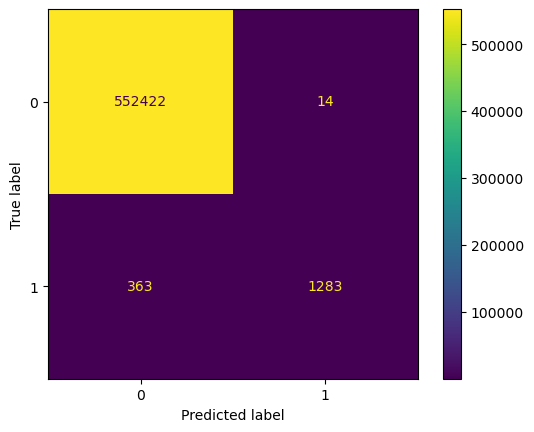

In [237]:
#classification report
from sklearn.metrics import classification_report
CR = classification_report(y_test, rfcy_pred)
print('Classification report \n' )
print(CR)
# Confusion Matrix
cm = confusion_matrix(y_test,rfcy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

***Classification Report and Confusion Matrix Display for Balanced Bagging Classifier***

Classification report 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552436
           1       0.95      0.84      0.89      1646

    accuracy                           1.00    554082
   macro avg       0.97      0.92      0.95    554082
weighted avg       1.00      1.00      1.00    554082



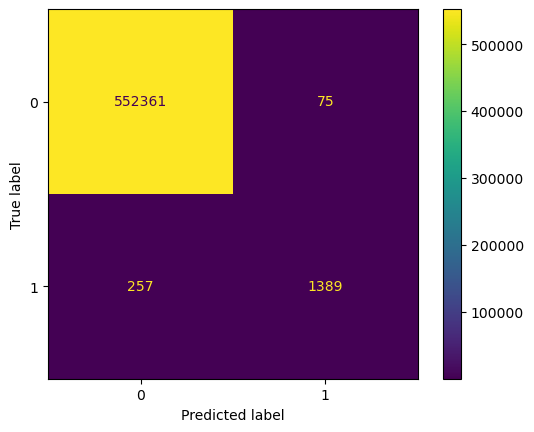

In [238]:
#classification report
from sklearn.metrics import classification_report
CR = classification_report(y_test, bbcy_pred)
print('Classification report \n' )
print(CR)
# Confusion Matrix
cm = confusion_matrix(y_test, bbcy_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# **Our main model is Balanced Bagging Classifier**

We get highest f1score with balanced bagging classifier which uses ramdon undersampler with decision tree algorithm. In random forest classifier a small, randomly selected subset of features is chosen for each bootstrap sample.
Again, random forest is very effective on a wide range of problems, but like bagging, performance of the standard algorithm is not great on imbalanced classification problems.


In learning extremely imbalanced data, there is a significant probability that a bootstrap sample contains few or even none of the minority class, resulting in a tree with poor performance for predicting the minority class. So, I think, BalancedBaggingClassifier is better.

# **Selecting Important Variables**

Tree-Based models are built by recursively splitting the feature space based on the target variable. Throughout the partitioning operation, the most informative feature is chosen to separate the data. The significance of a feature may be determined by calculating how much each characteristic decreases an impurity measure, such as Gini impurity or entropy.
Higher significance ratings indicate that qualities have a larger role in predicting the target variable.

In [239]:
feature_importances = permutation_importance(bbcpipeline, X_test, y_test, n_repeats=3, random_state=42)

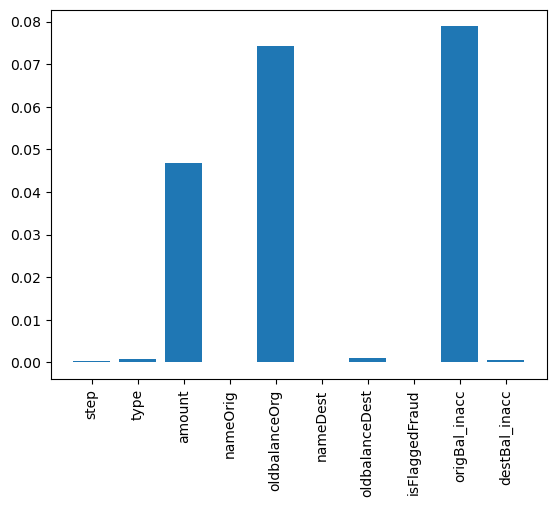

In [240]:
features = X_train.columns
importances = feature_importances.importances_mean

plt.bar(features, importances)
plt.xticks(rotation=90)
plt.show()

# **Describing our model**

Our fraud detection model is designed to identify potentially fraudulent transactions. The model utilizes a machine learning algorithm called Balanced Bagging Classifier to predict whether a given transaction is likely to be fraudulent or not.
The key factors in predicting fraudelent transactions are  amount, oldbalanceOrig, origBal_inacc

# **These factors make sense in the context of fraud detection for several reasons:**


'amount' : Unusually high transaction amounts can suggest fraud.

 Balance Changes: Large and unusual balance changes in the accounts of both the transaction initiator and the recipient can indicate fraudulent behavior.   

'step' : The timing of transactions is not important as fraudulent activities might occured during all time periods. 

'nameOrig' and 'nameDest' are not relevant since specific customers are not involved in repeated fraudulent activities.

 'type' feature's lower importance suggests that regular payment transactions have less predictive power for fraud detection.

# **Prevention Measures**

Implement real-time transaction monitoring systems that continuously analyze account activity for unusual patterns and large balance changes.
Utilize algorithms and machine learning models to identify abnormal account behaviors, such as sudden balance changes.
Set up thresholds for balance changes and transaction amounts that trigger alerts or require additional scrutiny.
Develop a robust alerting system that notifies relevant personnel or automated responses when suspicious activities are detected.
Analyze user and transaction behavior to establish baseline patterns and identify deviations that may indicate fraud.

# **Measuring Effectiveness**

Track the number and nature of incidents related to large and unusual balance changes before and after implementing prevention measures. A decrease in such incidents suggests improved effectiveness.

Monitor the rate at which alerts are triggered by the transaction monitoring system. A decrease in false positives (legitimate transactions triggering alerts) and an increase in true positives (fraudulent transactions) can indicate improved accuracy.

Measure the reduction in financial losses due to fraudulent transactions related to large and unusual balance changes. A decrease in such losses is a clear indicator of effectiveness.

Regularly review and analyze false-positive alerts to fine-tune the rules and models. Reducing false positives can improve the efficiency of fraud detection.